# Will it rain tomorrow in Australia?

The objective of this, is to find the best model that will predict if it will rain tomorrow in Australia. The data-set is from Kaggle, but we will load it from a github repositiry, as Kaggle downlaod service is not reliable.

We will start by importing all the libaries we require.

In [61]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

Loading the data into a pandas Data Frame.

In [62]:
df = pd.read_csv("https://raw.githubusercontent.com/medzz123/rain-data/main/weatherAUS.csv",  na_values=['NA', '?'])

## Resuffle Data?

Now lets check the summary of the data. This should give us the shape of the data, and its feature columns. 

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [64]:
df.count().sort_values()

Sunshine          75625
Evaporation       82670
Cloud3pm          86102
Cloud9am          89572
Pressure9am      130395
Pressure3pm      130432
WindDir9am       134894
WindGustDir      135134
WindGustSpeed    135197
Humidity3pm      140953
WindDir3pm       141232
Temp3pm          141851
RainTomorrow     142193
RainToday        142199
Rainfall         142199
WindSpeed3pm     142398
Humidity9am      142806
Temp9am          143693
WindSpeed9am     143693
MinTemp          143975
MaxTemp          144199
Location         145460
Date             145460
dtype: int64

We can observe that there is a total of 145460 entries with 23 columns. There are lot of columns which contains null values. 

Our target is `RainTomorrow`. As this column contains null values, we can drop those entries, as we won't be able test the accuracy of our model of those entries. 

We will also drop Location, as it the objective is to find out if it will rain tomorrow in Australia, not in a specific location. 

In [65]:
target = 'RainTomorrow'

df = df.drop(columns=['Location'],axis=1)

df = df[df[target].notna()]

df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [66]:
df.shape

(142193, 22)

We can observe that arround 3 thousand entries have dropped. Now we need to observe the type of our target. 

In [67]:
df[target].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

We can see that `RainTomorrow` can either be `Yes` or `No` which translates to Classification problem. Lets check the propoptions between these two. 

In [68]:
df[target].value_counts()/len(df)

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64

We can observe that in Australia it rains only 22% of the time. Lets plot this a chart.

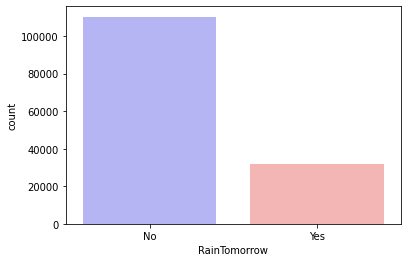

In [69]:
sns.countplot(x=target, data=df, palette="bwr")
plt.show()

This also shows that our dataset is imbalanced. This means that whichever model we use, we will get almost perfect accuracy. To mitigate that, we will oversample the minority values. This is done by generating new samples.

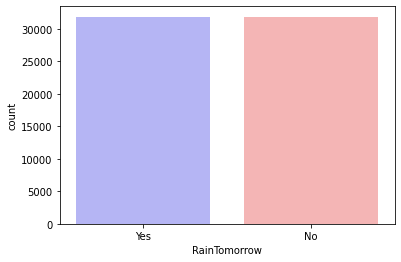

In [73]:
yesRain = df[df.RainTomorrow == "No"]
noRain = df[df.RainTomorrow == "Yes"]

yesOversampled = resample(yesRain, replace = True, n_samples=len(noRain), random_state=123)
df = pd.concat([noRain, yesOversampled])

sns.countplot(x='RainTomorrow', data=df, palette="bwr")
plt.show()

## Explore Values

In [74]:
categorical = [name for name in df.columns if df[name].dtype=='O']

df[categorical].head()

,Date,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
8,2008-12-09,NNW,SE,NW,No,Yes
10,2008-12-11,N,SSE,ESE,No,Yes
11,2008-12-12,NNE,NE,ENE,Yes,Yes
12,2008-12-13,W,NNW,NNW,Yes,Yes
16,2008-12-17,ENE,SSW,E,No,Yes


Look for missing values of the categorical values

In [75]:
df[categorical].isnull().sum()

Date               0
WindGustDir     4539
WindDir9am      4221
WindDir3pm      1823
RainToday        872
RainTomorrow       0
dtype: int64

Lets replace all missing ones with the most common one.

In [77]:
contains_null = [col for col in categorical if df[col].isnull().sum()!=0]

for col in contains_null:
  most_common = df[col].mode()
  df[col].fillna(most_common[0], inplace=True)

In [78]:
df[categorical].isnull().sum()

Date            0
WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [79]:
numerical = [name for name in df.columns if df[name].dtype!='O']

df[numerical].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
8,9.7,31.9,0.0,NaN,NaN,80.0,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2
10,13.4,30.4,0.0,NaN,NaN,30.0,17.0,6.0,48.0,22.0,1011.8,1008.7,NaN,NaN,20.4,28.8
11,15.9,21.7,2.2,NaN,NaN,31.0,15.0,13.0,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0
12,15.9,18.6,15.6,NaN,NaN,61.0,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8
16,14.1,20.9,0.0,NaN,NaN,22.0,11.0,9.0,69.0,82.0,1012.2,1010.4,8.0,1.0,17.2,18.1


Look for missing values in the numerical data

In [80]:
df[numerical].isnull().sum()

MinTemp            303
MaxTemp            167
Rainfall           872
Evaporation      27598
Sunshine         30431
WindGustSpeed     4508
WindSpeed9am       610
WindSpeed3pm      1236
Humidity9am        928
Humidity3pm       1802
Pressure9am       6399
Pressure3pm       6374
Cloud9am         23536
Cloud3pm         24851
Temp9am            490
Temp3pm           1357
dtype: int64

Lets check the info of the numerical values

In [81]:
df[numerical].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,63451.000000,63587.000000,62882.000000,36156.000000,33323.000000,59246.000000,63144.000000,62518.000000,62826.000000,61952.000000,57355.000000,57380.000000,40218.000000,38903.000000,63264.000000,62397.000000
mean,12.556989,22.532128,3.657594,5.163735,6.481766,42.140583,14.515805,19.155139,72.011699,57.567278,1016.477301,1014.186113,5.036725,5.204277,16.908482,20.850390
std,6.409591,7.133720,10.939951,3.994527,3.948733,14.654071,9.182765,9.149314,18.634546,21.839466,7.318027,7.254008,2.790765,2.617481,6.469056,6.947911
min,-7.800000,-4.100000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.000000,-4.400000
25%,7.900000,17.300000,0.000000,2.400000,3.100000,31.000000,7.000000,13.000000,60.000000,42.000000,1011.700000,1009.300000,2.000000,3.000000,12.200000,15.800000
50%,12.200000,21.800000,0.000000,4.400000,6.800000,41.000000,13.000000,19.000000,74.000000,58.000000,1016.400000,1014.100000,6.000000,6.000000,16.500000,20.200000
75%,17.300000,27.500000,2.200000,7.000000,9.900000,50.000000,20.000000,24.000000,87.000000,73.000000,1021.400000,1019.100000,7.000000,7.000000,21.400000,25.600000
max,30.700000,46.800000,371.000000,82.400000,14.500000,135.000000,87.000000,87.000000,100.000000,100.000000,1040.300000,1037.600000,8.000000,8.000000,39.400000,46.100000


Lets check if there are any outliers in numerical values by drawing some box plots.

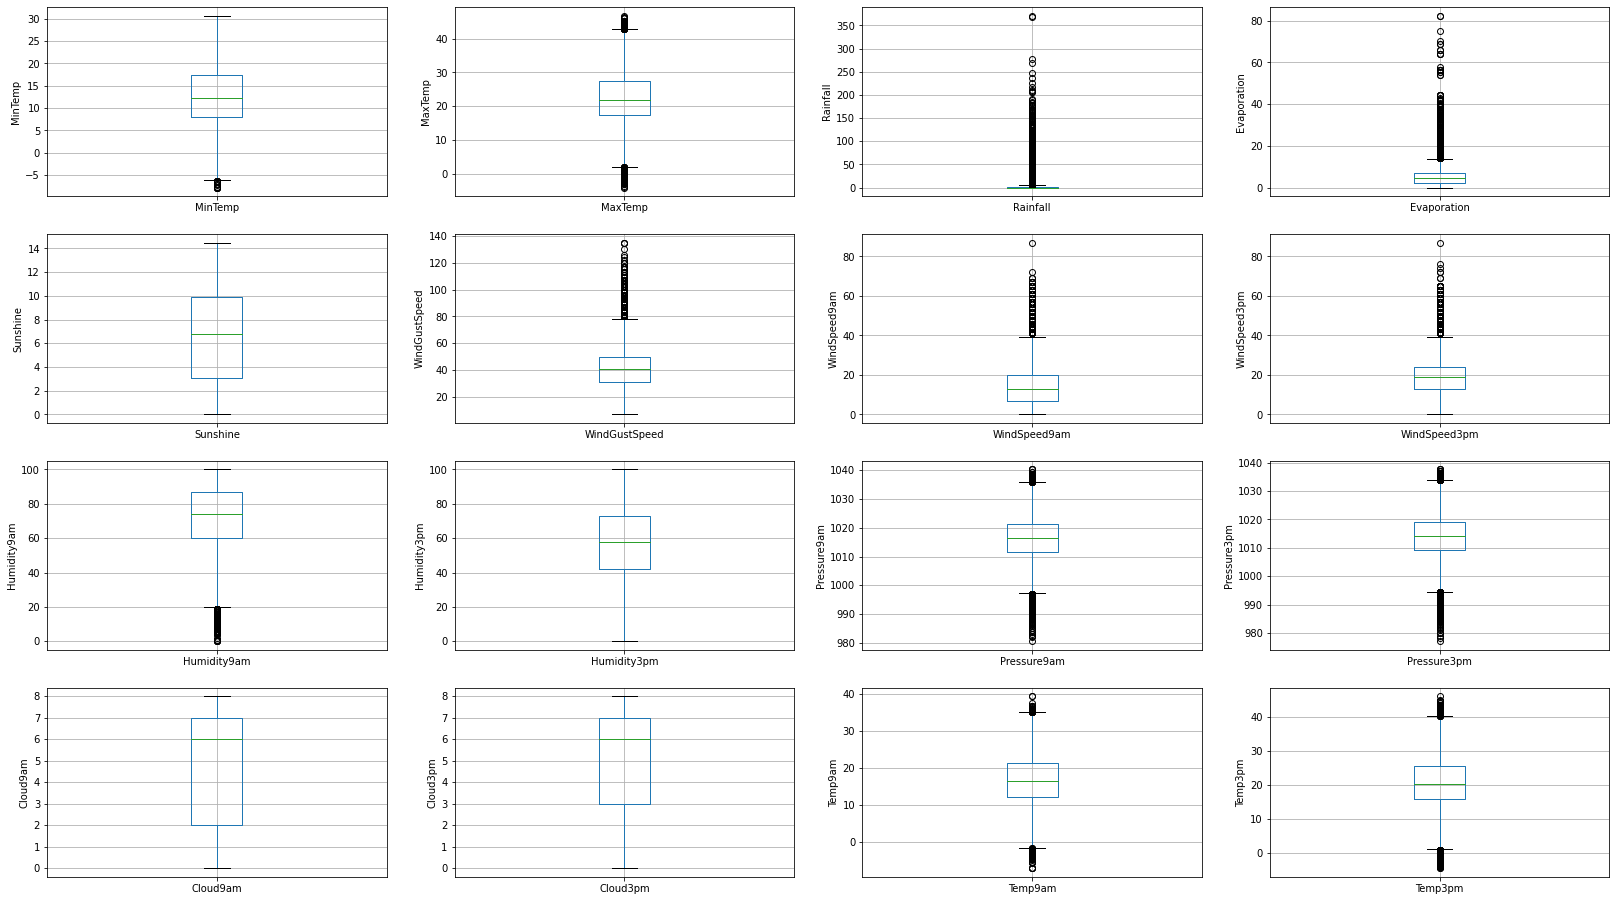

In [82]:
plt.figure(figsize=(28,16))

for index, value in enumerate(numerical):
  n = index + 1
  plt.subplot(4, 4, n)
  fig = df.boxplot(column=value)
  fig.set_ylabel(value)

We can observe from these that RainFall, WindSpeed 9am, WindSpeed 3pm and Evaporation might have outliers. Letse check these more in detail.

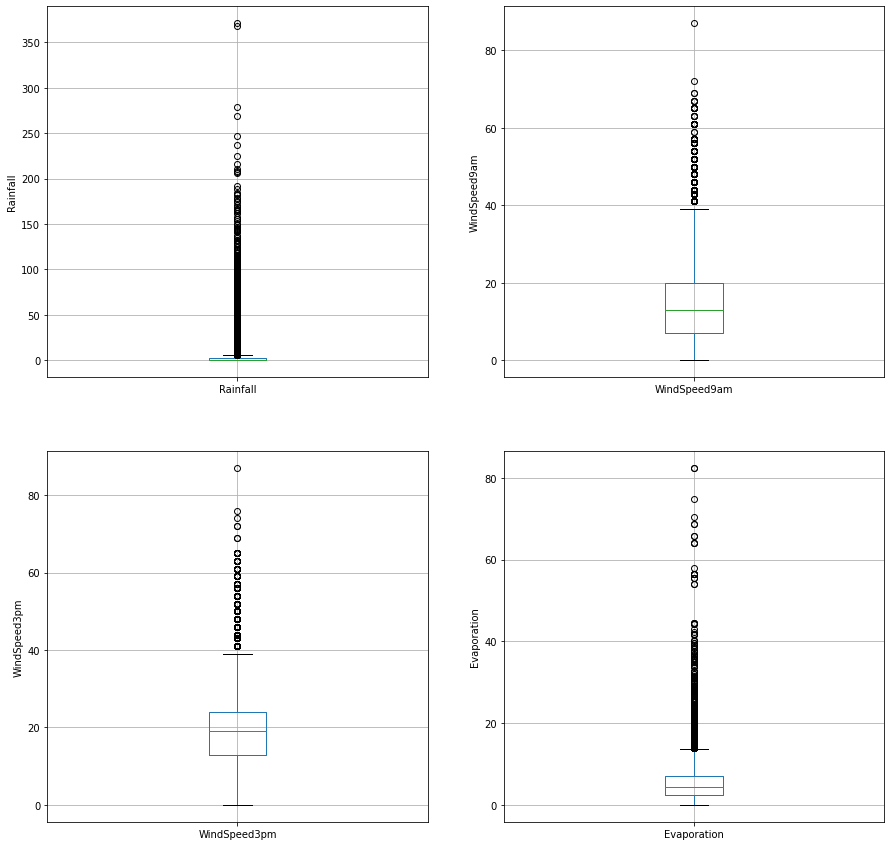

In [83]:
outliers = ['Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Evaporation']

plt.figure(figsize=(15,15))

for index, value in enumerate(outliers):
  n = index + 1
  plt.subplot(2, 2, n)
  fig = df.boxplot(column=value)
  fig.set_ylabel(value)

Finding the upper and lower bounds of the outliers using IQR

In [84]:
# Rainfall find outlier using IQR and replace

IQR = df.Rainfall.quantile(0.75) - df.Rainfall.quantile(0.25)
Upper_boundery = df.Rainfall.quantile(0.75) + (IQR * 3)

median = df['Rainfall'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["Rainfall"] = np.where(df["Rainfall"] >Upper_boundery, median,df['Rainfall'])

Upper boundary is: 8.8 and Median is 0.0


In [85]:
# Windspeed 9 am
IQR = df.WindSpeed9am.quantile(0.75) - df.WindSpeed9am.quantile(0.25)
Upper_boundery = df.WindSpeed9am.quantile(0.75) + (IQR * 3)

median = df['WindSpeed9am'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["WindSpeed9am"] = np.where(df["WindSpeed9am"] >Upper_boundery, median,df['WindSpeed9am'])

Upper boundary is: 59.0 and Median is 13.0


In [86]:
# Windspeed 3 pm
IQR = df.WindSpeed3pm.quantile(0.75) - df.WindSpeed3pm.quantile(0.25)
Upper_boundery = df.WindSpeed3pm.quantile(0.75) + (IQR * 3)

median = df['WindSpeed3pm'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["WindSpeed3pm"] = np.where(df["WindSpeed3pm"] >Upper_boundery, median,df['WindSpeed3pm'])

Upper boundary is: 57.0 and Median is 19.0


In [87]:
# Evaporation
IQR = df.Evaporation.quantile(0.75) - df.Evaporation.quantile(0.25)
Upper_boundery = df.Evaporation.quantile(0.75) + (IQR * 3)

median = df['Evaporation'].median()

print(f"Upper boundary is: {Upper_boundery} and Median is {median}")

df["Evaporation"] = np.where(df["Evaporation"] >Upper_boundery, median,df['Evaporation'])

Upper boundary is: 20.799999999999997 and Median is 4.4


Lets check the box plots after fixing the outliers

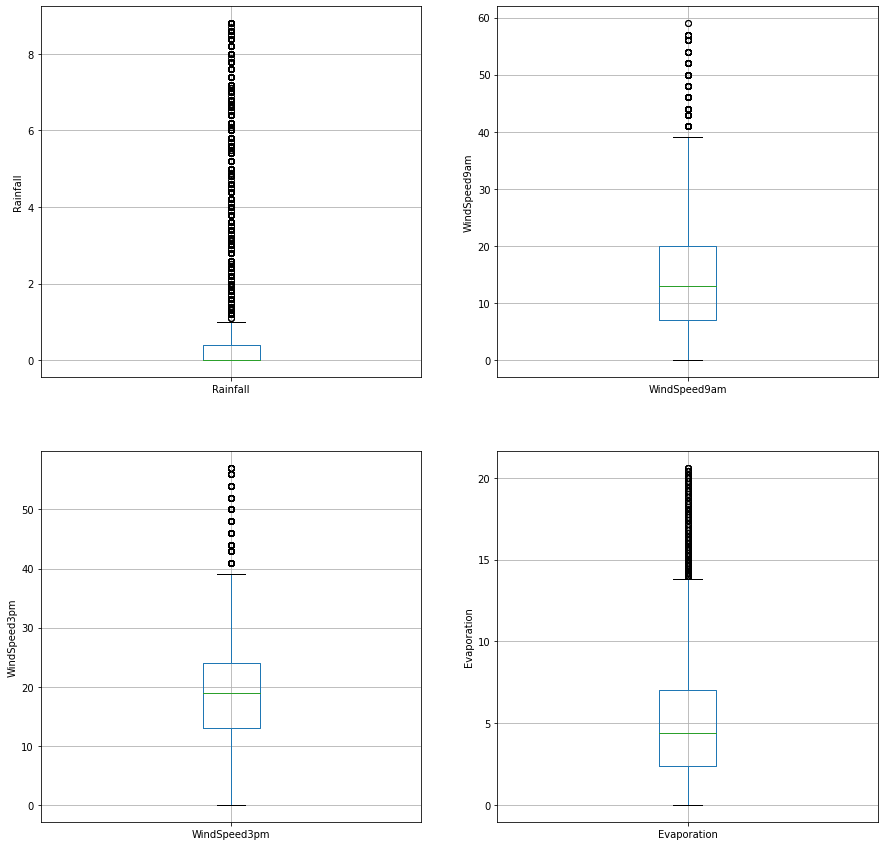

In [88]:
plt.figure(figsize=(15,15))

for index, value in enumerate(outliers):
  n = index + 1
  plt.subplot(2, 2, n)
  fig = df.boxplot(column=value)
  fig.set_ylabel(value)

Looks better now.

Now lets replaces all the NA numerical values with the median one.

In [89]:
for col in numerical:
  col_median = df[col].median()
  df[col].fillna(col_median, inplace=True)

df[numerical].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Now theres no null values anymore. Lastly encode categorical values




In [90]:
df = df.apply(LabelEncoder().fit_transform)

df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
8,270,167,345,0,44,68,6,39,9,7,4,15,41,9,222,193,6,6,230,341,0,1
10,272,204,330,0,44,68,3,12,10,2,9,3,47,22,251,244,6,6,251,327,0,1
11,273,229,243,22,44,68,5,13,4,1,8,7,88,91,238,199,8,8,206,209,1,1
12,274,229,212,0,44,68,13,29,6,6,15,15,75,93,76,87,8,8,221,197,1,1
16,278,211,235,0,44,68,1,8,11,0,6,5,68,82,255,261,8,1,219,220,0,1


Split data into train and test set

In [91]:
y = df[target]
X = df.drop([target], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((51003, 21), (12751, 21))

# Decision Tree Classifier

In [96]:
tree = DecisionTreeClassifier(criterion = 'entropy').fit(X_train,y_train)

y_pred_test = tree.predict(X_test)

score = accuracy_score(y_test, y_pred_test)

print(f'Model accuracy score: {score}')

Model accuracy score: 0.8610305074111835


Compare train and test set accuracy score

In [97]:
y_pred_train = tree.predict(X_train)

score2 = accuracy_score(y_train, y_pred_train)

print(f'Model accuracy score: {score2}')

Model accuracy score: 1.0


Plotting confusion matrices

In [98]:
def plot_confusion_matrix(cm):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar(fraction=0.5)
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

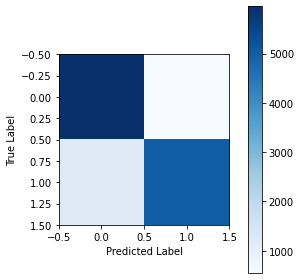

In [99]:
cm = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm)

Normalized confusion matrix


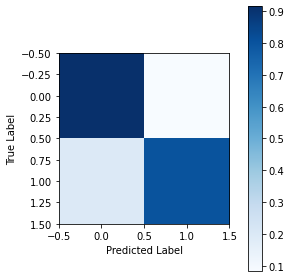

In [100]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plot_confusion_matrix(cm_normalized)

# Logistic Regression Model

In [101]:
logreg = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

y_pred_test = logreg.predict(X_test)

score = accuracy_score(y_test, y_pred_test)

print(f'Model accuracy score: {score}')

Model accuracy score: 0.7820563093090738


Compare againts test set

In [102]:
y_pred_train = logreg.predict(X_train)

score2 = accuracy_score(y_train, y_pred_train)

print(f'Model accuracy score: {score2}')

Model accuracy score: 0.7807972080073721


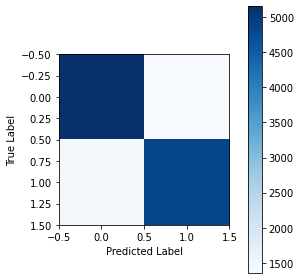

In [103]:
cm = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm)

Normalized confusion matrix


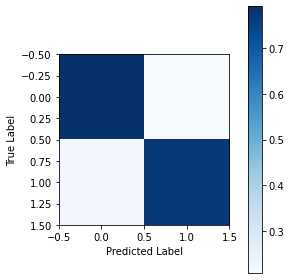

In [104]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plot_confusion_matrix(cm_normalized)